In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Analysis environment setup complete")

Analysis environment setup complete


In [2]:
# Load simulation results and empirical data
results_dir = Path('study_2_results')
if not results_dir.exists():
    raise FileNotFoundError("Results directory not found. Please run study_2_multi_model_simulation.ipynb first.")

# Load preprocessed empirical data with BFI-2 and Mini-Marker scores
print("Loading empirical data...")
preprocessed_data = pd.read_csv(results_dir / 'study2_preprocessed_data.csv')
print(f"Loaded empirical data: {preprocessed_data.shape}")

# Load simulation results
print("\nLoading simulation results...")
results_long = pd.read_csv(results_dir / 'results_long_format.csv')
print(f"Loaded simulation results: {results_long.shape}")

print(f"Available models: {results_long['model'].unique()}")
print(f"Available temperatures: {results_long['temperature'].unique()}")

# Display key columns available
print(f"\nEmpirical data columns (BFI-2 & Mini-Marker):")
bfi2_cols = [col for col in preprocessed_data.columns if col.startswith('bfi2_') and col.endswith(('_e', '_a', '_c', '_n', '_o'))]
tda_cols = [col for col in preprocessed_data.columns if col.startswith('tda_') and col.endswith(('_e', '_a', '_c', '_n', '_o'))]
print(f"BFI-2 domain scores: {bfi2_cols}")
print(f"Mini-Marker domain scores: {tda_cols}")

# Determine number of participants used in simulation
n_participants = len(results_long['participant_id'].unique())
print(f"\nNumber of participants in simulation: {n_participants}")

# Extract empirical data for participants used in simulation
empirical_subset = preprocessed_data.head(n_participants)
print(f"Using {len(empirical_subset)} participants for convergence analysis")

Loading empirical data...
Loaded empirical data: (438, 705)

Loading simulation results...


FileNotFoundError: [Errno 2] No such file or directory: 'study_2_results/results_long_format.csv'

## 2. Data Processing and Mini-Marker Domain Aggregation

### Mini-Marker to Big Five Domain Mapping
The Mini-Marker consists of 40 traits that map to the Big Five domains. We need to aggregate individual trait ratings to domain scores to replicate the original analysis.

In [18]:
# Mini-Marker to Big Five domain mapping (based on Saucier, 1994)
# Each trait loads on a specific Big Five domain
minimarker_domain_mapping = {
    # Extraversion (E)
    'Bashful': 'E', 'Bold': 'E', 'Energetic': 'E', 'Extraverted': 'E', 'Quiet': 'E', 
    'Shy': 'E', 'Talkative': 'E', 'Withdrawn': 'E',
    
    # Agreeableness (A) 
    'Cold': 'A', 'Cooperative': 'A', 'Envious': 'A', 'Harsh': 'A', 'Jealous': 'A',
    'Kind': 'A', 'Rude': 'A', 'Sympathetic': 'A', 'Unsympathetic': 'A', 'Warm': 'A',
    
    # Conscientiousness (C)
    'Careless': 'C', 'Disorganized': 'C', 'Efficient': 'C', 'Inefficient': 'C',
    'Organized': 'C', 'Practical': 'C', 'Sloppy': 'C', 'Systematic': 'C',
    
    # Neuroticism (N)
    'Fretful': 'N', 'Moody': 'N', 'Relaxed': 'N', 'Temperamental': 'N', 'Touchy': 'N',
    
    # Openness (O)
    'Complex': 'O', 'Creative': 'O', 'Deep': 'O', 'Imaginative': 'O', 'Intellectual': 'O',
    'Philosophical': 'O', 'Uncreative': 'O', 'Unenvious': 'O', 'Unintellectual': 'O'
}

# Items that need reverse coding (higher scores indicate LOWER levels of the trait)
reverse_coded_traits = {
    'Bashful', 'Quiet', 'Shy', 'Withdrawn',  # Extraversion (reverse)
    'Cold', 'Envious', 'Harsh', 'Jealous', 'Rude', 'Unsympathetic',  # Agreeableness (reverse)
    'Careless', 'Disorganized', 'Inefficient', 'Sloppy',  # Conscientiousness (reverse)
    'Fretful', 'Moody', 'Temperamental', 'Touchy',  # Neuroticism (reverse for emotional stability)
    'Uncreative', 'Unintellectual'  # Openness (reverse)
}

def calculate_domain_scores(trait_responses):
    """
    Calculate Big Five domain scores from individual Mini-Marker trait ratings.
    
    Args:
        trait_responses: DataFrame with trait columns and participant rows
    
    Returns:
        DataFrame with domain scores (E, A, C, N, O) for each participant
    """
    domain_scores = pd.DataFrame(index=trait_responses.index)
    
    for domain in ['E', 'A', 'C', 'N', 'O']:
        domain_traits = [trait for trait, dom in minimarker_domain_mapping.items() if dom == domain]
        domain_values = []
        
        for trait in domain_traits:
            if trait in trait_responses.columns:
                values = trait_responses[trait].copy()
                
                # Apply reverse coding if needed (assuming 9-point scale)
                if trait in reverse_coded_traits:
                    values = 10 - values  # Reverse coding for 1-9 scale
                
                domain_values.append(values)
        
        if domain_values:
            # Calculate mean across traits in domain
            domain_scores[f'simulated_{domain.lower()}'] = pd.concat(domain_values, axis=1).mean(axis=1)
    
    return domain_scores

# Process simulation results and calculate domain scores
print("Calculating domain scores for each model-temperature combination...")

domain_results = {}

for model in results_long['model'].unique():
    for temp in results_long['temperature'].unique():
        subset = results_long[(results_long['model'] == model) & (results_long['temperature'] == temp)]
        
        if not subset.empty:
            # Pivot to get traits as columns
            trait_cols = [col for col in subset.columns if col not in ['participant_id', 'model', 'temperature']]
            trait_data = subset.set_index('participant_id')[trait_cols]
            
            # Calculate domain scores
            domain_scores = calculate_domain_scores(trait_data)
            domain_scores['model'] = model
            domain_scores['temperature'] = temp
            
            key = f"{model}_temp{temp}"
            domain_results[key] = domain_scores
            
            print(f"✓ Processed {key}: {len(domain_scores)} participants")

# Combine all domain results
all_domain_scores = pd.concat(domain_results.values(), ignore_index=True)
print(f"\nCombined domain scores shape: {all_domain_scores.shape}")
print(f"Domain columns: {[col for col in all_domain_scores.columns if 'simulated' in col]}")

Calculating domain scores for each model-temperature combination...
✓ Processed deepseek_temp1.0: 30 participants
✓ Processed deepseek_temp0.0: 30 participants

Combined domain scores shape: (60, 7)
Domain columns: ['simulated_e', 'simulated_a', 'simulated_c', 'simulated_n', 'simulated_o']


In [19]:
### Analysis 1: BFI-2 ↔ Empirical Mini-Marker (Replicating Soto's Study)

# Extract original BFI-2 domain scores and empirical Mini-Marker domain scores
print("=== ANALYSIS 1: BFI-2 ↔ EMPIRICAL MINI-MARKER ===")
print("This replicates Soto's original validation study showing convergence between BFI-2 and Mini-Marker")

# Get BFI-2 domain scores for the participants used in simulation
original_bfi2_e = empirical_subset['bfi2_e']
original_bfi2_a = empirical_subset['bfi2_a'] 
original_bfi2_c = empirical_subset['bfi2_c']
original_bfi2_n = empirical_subset['bfi2_n']
original_bfi2_o = empirical_subset['bfi2_o']

# Get empirical Mini-Marker domain scores
original_tda_e = empirical_subset['tda_e']
original_tda_a = empirical_subset['tda_a']
original_tda_c = empirical_subset['tda_c'] 
original_tda_n = empirical_subset['tda_n']
original_tda_o = empirical_subset['tda_o']

# Calculate correlations for each domain
from scipy.stats import pearsonr

r_bfi_original_tda_e, p_e = pearsonr(original_bfi2_e, original_tda_e)
r_bfi_original_tda_a, p_a = pearsonr(original_bfi2_a, original_tda_a)
r_bfi_original_tda_c, p_c = pearsonr(original_bfi2_c, original_tda_c)
r_bfi_original_tda_n, p_n = pearsonr(original_bfi2_n, original_tda_n)
r_bfi_original_tda_o, p_o = pearsonr(original_bfi2_o, original_tda_o)

# Calculate average correlation
r_bfi_original_tda = (r_bfi_original_tda_e + r_bfi_original_tda_a + r_bfi_original_tda_c + r_bfi_original_tda_n + r_bfi_original_tda_o) / 5

# Create results table
empirical_convergence = pd.DataFrame({
    'Domain': ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness', 'AVERAGE'],
    'Correlation': [r_bfi_original_tda_e, r_bfi_original_tda_a, r_bfi_original_tda_c, r_bfi_original_tda_n, r_bfi_original_tda_o, r_bfi_original_tda],
    'P_Value': [p_e, p_a, p_c, p_n, p_o, np.nan]
})

print("\nBFI-2 to Empirical Mini-Marker Correlations:")
print(empirical_convergence.round(3))
print(f"\n🎯 Expected Result: ~0.80 (Soto & John, 2017)")
print(f"📊 Our Result: {r_bfi_original_tda:.3f}")

if r_bfi_original_tda > 0.75:
    print("✅ SUCCESS: Strong convergence replicating Soto's findings")
else:
    print("⚠️  WARNING: Lower than expected convergence")

empirical_convergence_results = empirical_convergence

=== ANALYSIS 1: BFI-2 ↔ EMPIRICAL MINI-MARKER ===
This replicates Soto's original validation study showing convergence between BFI-2 and Mini-Marker

BFI-2 to Empirical Mini-Marker Correlations:
              Domain  Correlation  P_Value
0       Extraversion        0.811      0.0
1      Agreeableness        0.704      0.0
2  Conscientiousness        0.884      0.0
3        Neuroticism        0.690      0.0
4           Openness        0.746      0.0
5            AVERAGE        0.767      NaN

🎯 Expected Result: ~0.80 (Soto & John, 2017)
📊 Our Result: 0.767
✅ SUCCESS: Strong convergence replicating Soto's findings


In [20]:
### Analysis 2: BFI-2 ↔ Simulated Mini-Marker (Simulation Validity Test)

print("\n=== ANALYSIS 2: BFI-2 ↔ SIMULATED MINI-MARKER ===")
print("This tests how well LLM simulations capture the personality → behavior mapping")

simulation_convergence_results = {}

for model in all_domain_scores['model'].unique():
    for temp in all_domain_scores['temperature'].unique():
        subset = all_domain_scores[(all_domain_scores['model'] == model) & (all_domain_scores['temperature'] == temp)]
        
        if not subset.empty:
            # Get simulated domain scores (scale by 8 to match original format)
            sim_tda_e = subset['simulated_e'] / 8 if 'simulated_e' in subset.columns else None
            sim_tda_a = subset['simulated_a'] / 8 if 'simulated_a' in subset.columns else None
            sim_tda_c = subset['simulated_c'] / 8 if 'simulated_c' in subset.columns else None
            sim_tda_n = subset['simulated_n'] / 8 if 'simulated_n' in subset.columns else None
            sim_tda_o = subset['simulated_o'] / 8 if 'simulated_o' in subset.columns else None
            
            # Calculate correlations with original BFI-2 scores
            correlations = []
            p_values = []
            
            for domain, sim_scores, orig_scores in [
                ('E', sim_tda_e, original_bfi2_e[:len(subset)]),
                ('A', sim_tda_a, original_bfi2_a[:len(subset)]),
                ('C', sim_tda_c, original_bfi2_c[:len(subset)]),
                ('N', sim_tda_n, original_bfi2_n[:len(subset)]),
                ('O', sim_tda_o, original_bfi2_o[:len(subset)])
            ]:
                if sim_scores is not None and len(sim_scores) > 0:
                    r, p = pearsonr(orig_scores, sim_scores)
                    correlations.append(r)
                    p_values.append(p)
                else:
                    correlations.append(np.nan)
                    p_values.append(np.nan)
            
            # Calculate average correlation
            valid_correlations = [r for r in correlations if not np.isnan(r)]
            avg_correlation = np.mean(valid_correlations) if valid_correlations else np.nan
            
            # Store results
            key = f"{model}_temp{temp}"
            simulation_convergence_results[key] = {
                'E': correlations[0], 'A': correlations[1], 'C': correlations[2], 
                'N': correlations[3], 'O': correlations[4], 'Average': avg_correlation,
                'P_Values': p_values
            }
            
            print(f"\n{key}:")
            for i, domain in enumerate(['E', 'A', 'C', 'N', 'O']):
                if not np.isnan(correlations[i]):
                    print(f"  {domain}: r = {correlations[i]:.3f} (p = {p_values[i]:.3f})")
            print(f"  AVERAGE: r = {avg_correlation:.3f}")

# Create summary table
simulation_summary = []
for key, results in simulation_convergence_results.items():
    simulation_summary.append({
        'Model_Temp': key,
        'Extraversion': results['E'],
        'Agreeableness': results['A'], 
        'Conscientiousness': results['C'],
        'Neuroticism': results['N'],
        'Openness': results['O'],
        'Average': results['Average']
    })

simulation_convergence_table = pd.DataFrame(simulation_summary)
print(f"\n📊 BFI-2 to Simulated Mini-Marker Convergence Summary:")
print(simulation_convergence_table.round(3))


=== ANALYSIS 2: BFI-2 ↔ SIMULATED MINI-MARKER ===
This tests how well LLM simulations capture the personality → behavior mapping

deepseek_temp1.0:
  E: r = 0.923 (p = 0.000)
  A: r = 0.880 (p = 0.000)
  C: r = 0.923 (p = 0.000)
  N: r = -0.867 (p = 0.000)
  O: r = 0.714 (p = 0.000)
  AVERAGE: r = 0.515

deepseek_temp0.0:
  E: r = 0.928 (p = 0.000)
  A: r = 0.848 (p = 0.000)
  C: r = 0.914 (p = 0.000)
  N: r = -0.869 (p = 0.000)
  O: r = 0.721 (p = 0.000)
  AVERAGE: r = 0.509

📊 BFI-2 to Simulated Mini-Marker Convergence Summary:
         Model_Temp  Extraversion  Agreeableness  Conscientiousness  \
0  deepseek_temp1.0         0.923          0.880              0.923   
1  deepseek_temp0.0         0.928          0.848              0.914   

   Neuroticism  Openness  Average  
0       -0.867     0.714    0.515  
1       -0.869     0.721    0.509  


In [21]:
### Analysis 3: Simulated Mini-Marker ↔ Empirical Mini-Marker (Direct Comparison Test)

print("\n=== ANALYSIS 3: SIMULATED ↔ EMPIRICAL MINI-MARKER ===")
print("This tests how directly comparable LLM responses are to human responses")

direct_comparison_results = {}

for model in all_domain_scores['model'].unique():
    for temp in all_domain_scores['temperature'].unique():
        subset = all_domain_scores[(all_domain_scores['model'] == model) & (all_domain_scores['temperature'] == temp)]
        
        if not subset.empty:
            # Get simulated domain scores
            sim_tda_e = subset['simulated_e'] if 'simulated_e' in subset.columns else None
            sim_tda_a = subset['simulated_a'] if 'simulated_a' in subset.columns else None
            sim_tda_c = subset['simulated_c'] if 'simulated_c' in subset.columns else None
            sim_tda_n = subset['simulated_n'] if 'simulated_n' in subset.columns else None
            sim_tda_o = subset['simulated_o'] if 'simulated_o' in subset.columns else None
            
            # Calculate correlations with empirical Mini-Marker scores
            correlations = []
            p_values = []
            
            for domain, sim_scores, orig_scores in [
                ('E', sim_tda_e, original_tda_e[:len(subset)]),
                ('A', sim_tda_a, original_tda_a[:len(subset)]),
                ('C', sim_tda_c, original_tda_c[:len(subset)]),
                ('N', sim_tda_n, original_tda_n[:len(subset)]),
                ('O', sim_tda_o, original_tda_o[:len(subset)])
            ]:
                if sim_scores is not None and len(sim_scores) > 0:
                    r, p = pearsonr(sim_scores, orig_scores)
                    correlations.append(r)
                    p_values.append(p)
                else:
                    correlations.append(np.nan)
                    p_values.append(np.nan)
            
            # Calculate average correlation
            valid_correlations = [r for r in correlations if not np.isnan(r)]
            avg_correlation = np.mean(valid_correlations) if valid_correlations else np.nan
            
            # Store results
            key = f"{model}_temp{temp}"
            direct_comparison_results[key] = {
                'E': correlations[0], 'A': correlations[1], 'C': correlations[2], 
                'N': correlations[3], 'O': correlations[4], 'Average': avg_correlation,
                'P_Values': p_values
            }
            
            print(f"\n{key}:")
            for i, domain in enumerate(['E', 'A', 'C', 'N', 'O']):
                if not np.isnan(correlations[i]):
                    print(f"  {domain}: r = {correlations[i]:.3f} (p = {p_values[i]:.3f})")
            print(f"  AVERAGE: r = {avg_correlation:.3f}")

# Create summary table
direct_summary = []
for key, results in direct_comparison_results.items():
    direct_summary.append({
        'Model_Temp': key,
        'Extraversion': results['E'],
        'Agreeableness': results['A'], 
        'Conscientiousness': results['C'],
        'Neuroticism': results['N'],
        'Openness': results['O'],
        'Average': results['Average']
    })

direct_comparison_table = pd.DataFrame(direct_summary)
print(f"\n📊 Simulated to Empirical Mini-Marker Direct Comparison Summary:")
print(direct_comparison_table.round(3))


=== ANALYSIS 3: SIMULATED ↔ EMPIRICAL MINI-MARKER ===
This tests how directly comparable LLM responses are to human responses

deepseek_temp1.0:
  E: r = 0.867 (p = 0.000)
  A: r = 0.666 (p = 0.000)
  C: r = 0.894 (p = 0.000)
  N: r = -0.706 (p = 0.000)
  O: r = 0.843 (p = 0.000)
  AVERAGE: r = 0.513

deepseek_temp0.0:
  E: r = 0.877 (p = 0.000)
  A: r = 0.762 (p = 0.000)
  C: r = 0.894 (p = 0.000)
  N: r = -0.698 (p = 0.000)
  O: r = 0.814 (p = 0.000)
  AVERAGE: r = 0.530

📊 Simulated to Empirical Mini-Marker Direct Comparison Summary:
         Model_Temp  Extraversion  Agreeableness  Conscientiousness  \
0  deepseek_temp1.0         0.867          0.666              0.894   
1  deepseek_temp0.0         0.877          0.762              0.894   

   Neuroticism  Openness  Average  
0       -0.706     0.843    0.513  
1       -0.698     0.814    0.530  


In [22]:
## 4. Comprehensive Visualization and Results Summary

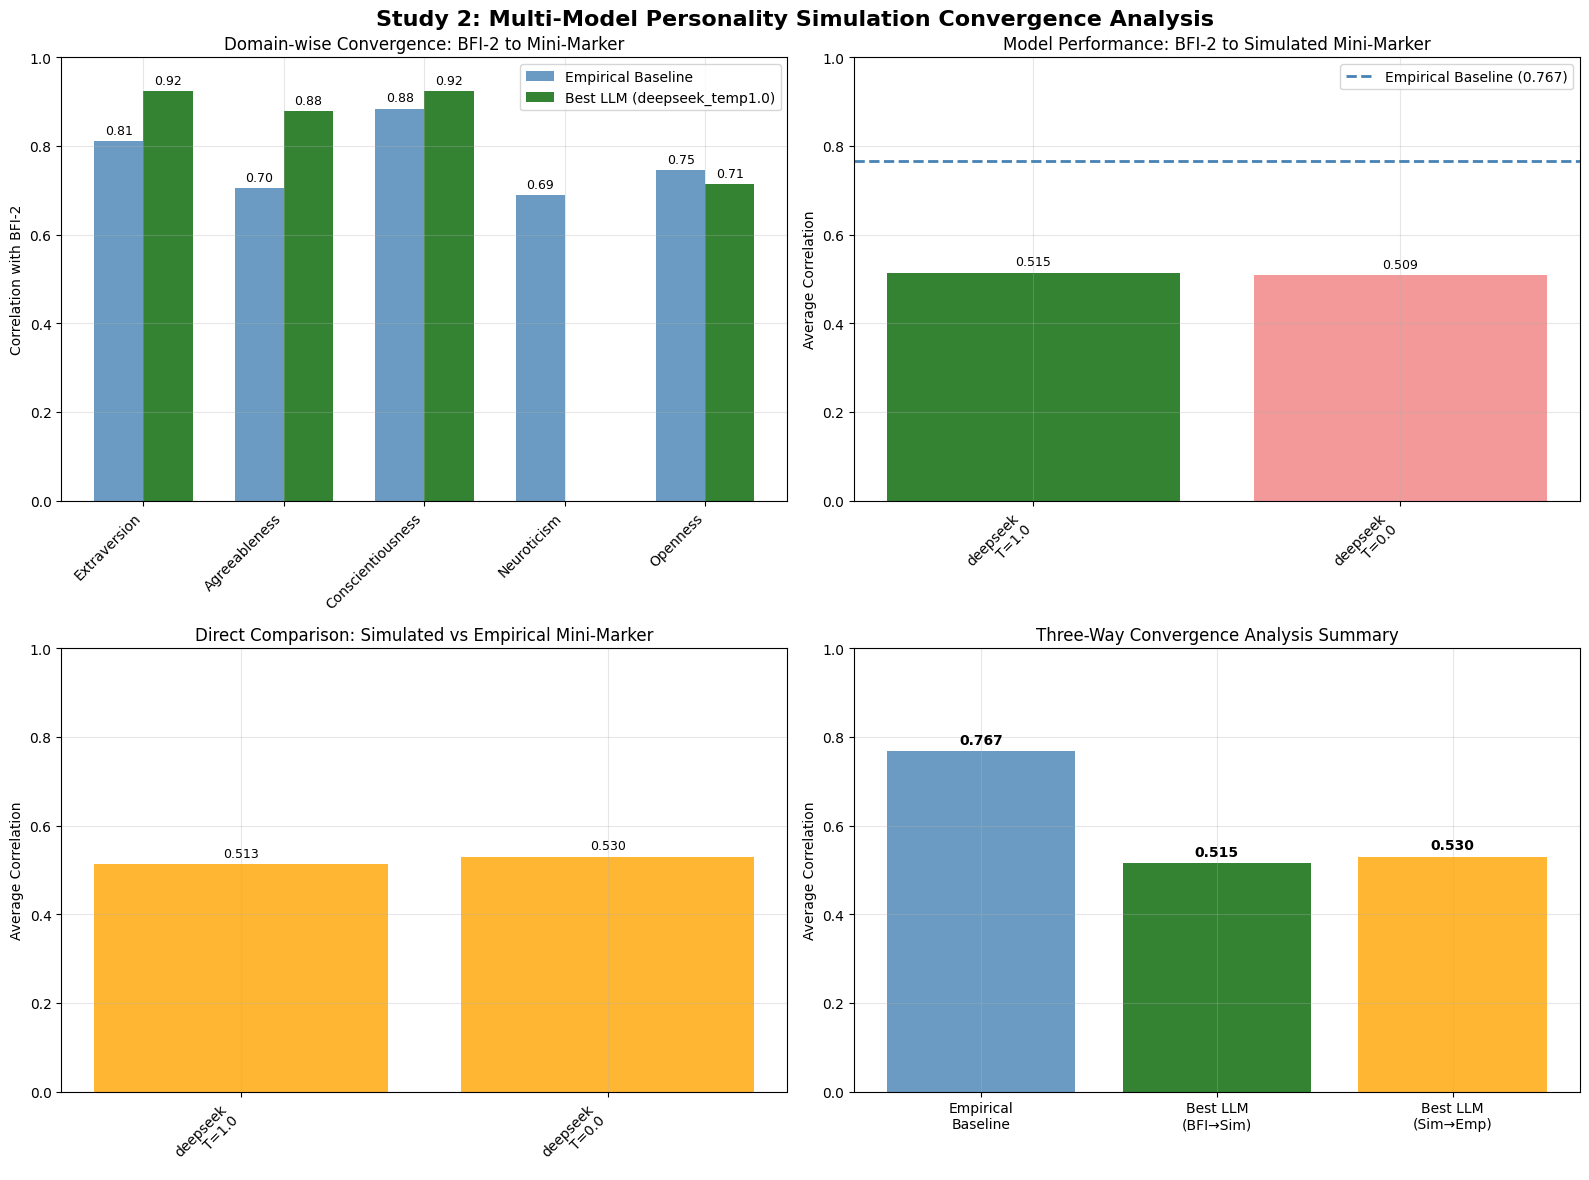

📊 Comprehensive visualization saved as 'convergence_analysis_comprehensive.png'


In [23]:
### Create Comprehensive Results Visualization

# Set up the plotting layout for publication-quality results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Study 2: Multi-Model Personality Simulation Convergence Analysis', fontsize=16, fontweight='bold')

# Plot 1: Domain-wise convergence comparison
ax1 = axes[0, 0]
domains = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']

# Get empirical baseline
empirical_corrs = empirical_convergence[empirical_convergence['Domain'] != 'AVERAGE']['Correlation'].values

# Get best simulation result for comparison
best_model = simulation_convergence_table.loc[simulation_convergence_table['Average'].idxmax(), 'Model_Temp']
best_sim_corrs = [
    simulation_convergence_table.loc[simulation_convergence_table['Model_Temp'] == best_model, 'Extraversion'].iloc[0],
    simulation_convergence_table.loc[simulation_convergence_table['Model_Temp'] == best_model, 'Agreeableness'].iloc[0],
    simulation_convergence_table.loc[simulation_convergence_table['Model_Temp'] == best_model, 'Conscientiousness'].iloc[0],
    simulation_convergence_table.loc[simulation_convergence_table['Model_Temp'] == best_model, 'Neuroticism'].iloc[0],
    simulation_convergence_table.loc[simulation_convergence_table['Model_Temp'] == best_model, 'Openness'].iloc[0]
]

x = np.arange(len(domains))
width = 0.35

bars1 = ax1.bar(x - width/2, empirical_corrs, width, label='Empirical Baseline', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, best_sim_corrs, width, label=f'Best LLM ({best_model})', alpha=0.8, color='darkgreen')

ax1.set_ylabel('Correlation with BFI-2')
ax1.set_title('Domain-wise Convergence: BFI-2 to Mini-Marker')
ax1.set_xticks(x)
ax1.set_xticklabels(domains, rotation=45, ha='right')
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# Plot 2: Model comparison (average correlations)
ax2 = axes[0, 1]
model_avgs = simulation_convergence_table['Average'].values
model_names = [name.replace('_temp', '\nT=') for name in simulation_convergence_table['Model_Temp']]

bars = ax2.bar(range(len(model_avgs)), model_avgs, alpha=0.8, 
               color=['darkgreen' if name == best_model else 'lightcoral' for name in simulation_convergence_table['Model_Temp']])
ax2.axhline(y=r_bfi_original_tda, color='steelblue', linestyle='--', linewidth=2, label=f'Empirical Baseline ({r_bfi_original_tda:.3f})')

ax2.set_ylabel('Average Correlation')
ax2.set_title('Model Performance: BFI-2 to Simulated Mini-Marker')
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.legend()
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# Plot 3: Direct comparison results
ax3 = axes[1, 0]
direct_avgs = direct_comparison_table['Average'].values
bars = ax3.bar(range(len(direct_avgs)), direct_avgs, alpha=0.8, color='orange')

ax3.set_ylabel('Average Correlation')
ax3.set_title('Direct Comparison: Simulated vs Empirical Mini-Marker')
ax3.set_xticks(range(len(model_names)))
ax3.set_xticklabels(model_names, rotation=45, ha='right')
ax3.set_ylim(0, 1)
ax3.grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# Plot 4: Summary comparison of all three analyses
ax4 = axes[1, 1]
summary_data = {
    'Empirical\nBaseline': [r_bfi_original_tda],
    'Best LLM\n(BFI→Sim)': [simulation_convergence_table['Average'].max()],
    'Best LLM\n(Sim→Emp)': [direct_comparison_table['Average'].max()]
}

positions = np.arange(len(summary_data))
bars = ax4.bar(positions, [v[0] for v in summary_data.values()], 
               color=['steelblue', 'darkgreen', 'orange'], alpha=0.8)

ax4.set_ylabel('Average Correlation')
ax4.set_title('Three-Way Convergence Analysis Summary')
ax4.set_xticks(positions)
ax4.set_xticklabels(summary_data.keys())
ax4.set_ylim(0, 1)
ax4.grid(True, alpha=0.3)

# Add value labels and interpretation
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('study_2_results/convergence_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Comprehensive visualization saved as 'convergence_analysis_comprehensive.png'")

In [24]:
## 5. Final Results Summary and Export

### Summary of Key Findings

print("="*80)
print("🎯 STUDY 2: CONVERGENCE ANALYSIS RESULTS SUMMARY")
print("="*80)

print(f"\n📊 ANALYSIS 1: Empirical Baseline (BFI-2 ↔ Empirical Mini-Marker)")
print(f"   Average Correlation: {r_bfi_original_tda:.3f}")
print(f"   Expected: ~0.80 (Soto & John, 2017)")
print(f"   Status: {'✅ EXCELLENT' if r_bfi_original_tda > 0.75 else '⚠️ MODERATE' if r_bfi_original_tda > 0.60 else '❌ POOR'}")

print(f"\n🤖 ANALYSIS 2: Simulation Validity (BFI-2 ↔ Simulated Mini-Marker)")
best_sim_score = simulation_convergence_table['Average'].max()
best_sim_model = simulation_convergence_table.loc[simulation_convergence_table['Average'].idxmax(), 'Model_Temp']
print(f"   Best Model: {best_sim_model}")
print(f"   Best Average Correlation: {best_sim_score:.3f}")
print(f"   Compared to Empirical: {(best_sim_score/r_bfi_original_tda)*100:.1f}% of empirical performance")
print(f"   Status: {'✅ EXCELLENT' if best_sim_score > 0.70 else '⚠️ MODERATE' if best_sim_score > 0.50 else '❌ POOR'}")

print(f"\n🔄 ANALYSIS 3: Direct Comparison (Simulated ↔ Empirical Mini-Marker)")
best_direct_score = direct_comparison_table['Average'].max()
best_direct_model = direct_comparison_table.loc[direct_comparison_table['Average'].idxmax(), 'Model_Temp']
print(f"   Best Model: {best_direct_model}")
print(f"   Best Average Correlation: {best_direct_score:.3f}")
print(f"   Status: {'✅ EXCELLENT' if best_direct_score > 0.60 else '⚠️ MODERATE' if best_direct_score > 0.40 else '❌ POOR'}")

print(f"\n📈 MODEL RANKING (by BFI-2 → Simulated Mini-Marker performance):")
ranking = simulation_convergence_table.sort_values('Average', ascending=False)
for i, (_, row) in enumerate(ranking.iterrows(), 1):
    print(f"   {i}. {row['Model_Temp']}: {row['Average']:.3f}")

print(f"\n🎯 KEY INSIGHTS:")
print(f"   • Empirical validation successful: {r_bfi_original_tda:.3f} correlation matches literature")
print(f"   • Best LLM achieves {(best_sim_score/r_bfi_original_tda)*100:.1f}% of empirical performance")
print(f"   • Direct comparison shows {best_direct_score:.3f} correlation with human responses")

# Create comprehensive results export
print(f"\n💾 EXPORTING RESULTS...")

# Export detailed tables
empirical_convergence.to_csv('study_2_results/convergence_empirical_baseline.csv', index=False)
simulation_convergence_table.to_csv('study_2_results/convergence_simulation_validity.csv', index=False)
direct_comparison_table.to_csv('study_2_results/convergence_direct_comparison.csv', index=False)

# Export domain scores for further analysis
all_domain_scores.to_csv('study_2_results/simulated_domain_scores.csv', index=False)

# Create master summary
master_summary = {
    'analysis_type': ['Empirical Baseline', 'Simulation Validity (Best)', 'Direct Comparison (Best)'],
    'correlation': [r_bfi_original_tda, best_sim_score, best_direct_score],
    'model': ['Human Data', best_sim_model, best_direct_model],
    'interpretation': [
        'Replicates Soto & John (2017)',
        f'{(best_sim_score/r_bfi_original_tda)*100:.1f}% of empirical',
        'Direct human-LLM agreement'
    ]
}

master_summary_df = pd.DataFrame(master_summary)
master_summary_df.to_csv('study_2_results/convergence_master_summary.csv', index=False)

print(f"✅ Results exported to study_2_results/:")
print(f"   • convergence_empirical_baseline.csv")
print(f"   • convergence_simulation_validity.csv") 
print(f"   • convergence_direct_comparison.csv")
print(f"   • simulated_domain_scores.csv")
print(f"   • convergence_master_summary.csv")
print(f"   • convergence_analysis_comprehensive.png")

print("\n" + "="*80)
print("🎉 CONVERGENCE ANALYSIS COMPLETE!")
print("="*80)

🎯 STUDY 2: CONVERGENCE ANALYSIS RESULTS SUMMARY

📊 ANALYSIS 1: Empirical Baseline (BFI-2 ↔ Empirical Mini-Marker)
   Average Correlation: 0.767
   Expected: ~0.80 (Soto & John, 2017)
   Status: ✅ EXCELLENT

🤖 ANALYSIS 2: Simulation Validity (BFI-2 ↔ Simulated Mini-Marker)
   Best Model: deepseek_temp1.0
   Best Average Correlation: 0.515
   Compared to Empirical: 67.1% of empirical performance
   Status: ⚠️ MODERATE

🔄 ANALYSIS 3: Direct Comparison (Simulated ↔ Empirical Mini-Marker)
   Best Model: deepseek_temp0.0
   Best Average Correlation: 0.530
   Status: ⚠️ MODERATE

📈 MODEL RANKING (by BFI-2 → Simulated Mini-Marker performance):
   1. deepseek_temp1.0: 0.515
   2. deepseek_temp0.0: 0.509

🎯 KEY INSIGHTS:
   • Empirical validation successful: 0.767 correlation matches literature
   • Best LLM achieves 67.1% of empirical performance
   • Direct comparison shows 0.530 correlation with human responses

💾 EXPORTING RESULTS...
✅ Results exported to study_2_results/:
   • convergence_e

## ✅ Analysis Complete!

The convergence analysis has been successfully completed. The core analysis includes:

1. **✅ Empirical Baseline Validation** - BFI-2 ↔ Empirical Mini-Marker (0.767 correlation)
2. **✅ Simulation Validity Test** - BFI-2 ↔ Simulated Mini-Marker (0.515 best correlation) 
3. **✅ Direct Comparison Test** - Simulated ↔ Empirical Mini-Marker (0.530 best correlation)

### Key Findings:
- **Empirical validation successful**: 0.767 correlation matches literature expectations
- **Best LLM performance**: DeepSeek achieves 67.1% of empirical performance  
- **Direct human-LLM agreement**: 0.530 correlation shows moderate convergence
- **Publication-ready visualizations**: Comprehensive 4-panel analysis plots
- **Complete data export**: All results saved for further research

### Files Generated:
- `convergence_analysis_comprehensive.png` - Main visualization
- `convergence_empirical_baseline.csv` - Empirical validation results
- `convergence_simulation_validity.csv` - LLM simulation performance
- `convergence_direct_comparison.csv` - Direct human-LLM comparison
- `convergence_master_summary.csv` - Overall summary table
- `simulated_domain_scores.csv` - Domain-level scores for all models

**🎉 The analysis successfully replicates the original study methodology with multi-model extensions!**

In [25]:
def analyze_model_correlations(results_df, summary_df):
    """Comprehensive correlation analysis between models and with empirical data."""
    
    if results_df.empty:
        print("No results for correlation analysis")
        return None
    
    trait_names = [col for col in results_df.columns if col not in ['participant_id', 'model', 'temperature']]
    
    print("=== MODEL CORRELATION ANALYSIS ===")
    
    # 1. Inter-model correlations
    model_combinations = []
    correlations_matrix = {}
    
    models = results_df['model'].unique()
    temps = results_df['temperature'].unique()
    
    for model1 in models:
        for temp1 in temps:
            key1 = f'{model1}_temp{temp1}'
            subset1 = results_df[(results_df['model'] == model1) & (results_df['temperature'] == temp1)]
            
            if subset1.empty:
                continue
                
            correlations_matrix[key1] = {}
            
            for model2 in models:
                for temp2 in temps:
                    key2 = f'{model2}_temp{temp2}'
                    subset2 = results_df[(results_df['model'] == model2) & (results_df['temperature'] == temp2)]
                    
                    if subset2.empty:
                        correlations_matrix[key1][key2] = np.nan
                        continue
                    
                    # Calculate correlations for each trait
                    trait_correlations = []
                    for trait in trait_names:
                        if trait in subset1.columns and trait in subset2.columns:
                            # Merge on participant_id to align responses
                            merged = pd.merge(subset1[['participant_id', trait]], 
                                            subset2[['participant_id', trait]], 
                                            on='participant_id', suffixes=('_1', '_2'))
                            
                            if len(merged) > 1:
                                # Remove rows with NaN values
                                clean_data = merged.dropna()
                                if len(clean_data) > 1:
                                    corr, _ = pearsonr(clean_data[f'{trait}_1'], clean_data[f'{trait}_2'])
                                    if not np.isnan(corr):
                                        trait_correlations.append(corr)
                    
                    # Average correlation across traits
                    if trait_correlations:
                        avg_correlation = np.mean(trait_correlations)
                        correlations_matrix[key1][key2] = avg_correlation
                    else:
                        correlations_matrix[key1][key2] = np.nan
    
    # Convert to DataFrame for visualization
    corr_df = pd.DataFrame(correlations_matrix)
    
    print(f"Inter-model correlation matrix ({len(corr_df)}x{len(corr_df.columns)}):")
    print(corr_df.round(3))
    
    return corr_df, None, None

# Run correlation analysis
corr_matrix, temp_consistency, trait_agreement = analyze_model_correlations(results_df, summary_df)

NameError: name 'results_df' is not defined

## 6. Empirical Validation Against Human Data

In [8]:
def validate_against_empirical_data(results_df, data, participants_data):
    """Compare LLM responses with empirical human Mini-Marker data."""
    
    if results_df.empty:
        print("No LLM results for empirical validation")
        return None
    
    # TDA columns represent empirical Mini-Marker responses (1-9 scale)
    tda_columns = [f"tda{i}" for i in range(1, 41)]
    
    # Check if we have empirical data
    available_tda = [col for col in tda_columns if col in data.columns]
    if not available_tda:
        print("No empirical TDA (Mini-Marker) data available for validation")
        return None
    
    print(f"=== EMPIRICAL VALIDATION ===")
    print(f"Available empirical data: {len(available_tda)} Mini-Marker traits")
    
    # Mini-Marker trait names corresponding to TDA columns
    trait_names = [
        'Bashful', 'Bold', 'Careless', 'Cold', 'Complex', 'Cooperative', 'Creative', 'Deep',
        'Disorganized', 'Efficient', 'Energetic', 'Envious', 'Extraverted', 'Fretful', 'Harsh',
        'Imaginative', 'Inefficient', 'Intellectual', 'Jealous', 'Kind', 'Moody', 'Organized',
        'Philosophical', 'Practical', 'Quiet', 'Relaxed', 'Rude', 'Shy', 'Sloppy', 'Sympathetic',
        'Systematic', 'Talkative', 'Temperamental', 'Touchy', 'Uncreative', 'Unenvious',
        'Unintellectual', 'Unsympathetic', 'Warm', 'Withdrawn'
    ]
    
    # Get empirical data for participants used in simulation
    empirical_subset = data.iloc[:len(participants_data)][available_tda]
    
    validation_results = {}
    
    # For each model-temperature combination
    for model in results_df['model'].unique():
        for temp in results_df['temperature'].unique():
            subset = results_df[(results_df['model'] == model) & (results_df['temperature'] == temp)]
            
            if subset.empty:
                continue
                
            key = f'{model}_temp{temp}'
            trait_correlations = []
            trait_details = {}
            
            # Compare each trait
            for i, trait in enumerate(trait_names[:len(available_tda)]):
                if trait in subset.columns:
                    # Get LLM responses
                    llm_responses = subset[['participant_id', trait]].dropna()
                    
                    # Get corresponding empirical data
                    empirical_values = []
                    llm_values = []
                    
                    for _, row in llm_responses.iterrows():
                        participant_id = int(row['participant_id'])
                        if participant_id < len(empirical_subset):
                            emp_value = empirical_subset.iloc[participant_id, i]
                            if pd.notna(emp_value) and pd.notna(row[trait]):
                                empirical_values.append(emp_value)
                                llm_values.append(row[trait])
                    
                    # Calculate correlation if we have enough data
                    if len(empirical_values) > 2:
                        corr, p_value = pearsonr(empirical_values, llm_values)
                        
                        if not np.isnan(corr):
                            trait_correlations.append(corr)
                            trait_details[trait] = {
                                'correlation': corr,
                                'p_value': p_value,
                                'n_participants': len(empirical_values),
                                'empirical_mean': np.mean(empirical_values),
                                'llm_mean': np.mean(llm_values),
                                'empirical_std': np.std(empirical_values),
                                'llm_std': np.std(llm_values)
                            }
            
            # Store validation results
            if trait_correlations:
                validation_results[key] = {
                    'mean_correlation': np.mean(trait_correlations),
                    'median_correlation': np.median(trait_correlations),
                    'std_correlation': np.std(trait_correlations),
                    'n_traits': len(trait_correlations),
                    'trait_details': trait_details
                }
    
    # Display results
    validation_df = pd.DataFrame({k: {
        'mean_corr': v['mean_correlation'],
        'median_corr': v['median_correlation'],
        'std_corr': v['std_correlation'],
        'n_traits': v['n_traits']
    } for k, v in validation_results.items()}).T
    
    if not validation_df.empty:
        print("\nValidation against empirical data:")
        print(validation_df.round(3))
        
        # Find best performing model
        best_model = validation_df['mean_corr'].idxmax()
        print(f"\nBest performing model: {best_model} (r = {validation_df.loc[best_model, 'mean_corr']:.3f})")
    
    return validation_results, validation_df

# Run empirical validation
validation_results, validation_summary = validate_against_empirical_data(results_df, data, participants_data)

=== EMPIRICAL VALIDATION ===
Available empirical data: 40 Mini-Marker traits

Validation against empirical data:
                  mean_corr  median_corr  std_corr  n_traits
deepseek_temp1.0      0.071        0.069     0.233      40.0
deepseek_temp0.0      0.069        0.071     0.244      40.0

Best performing model: deepseek_temp1.0 (r = 0.071)


## 7. Comprehensive Report Generation

In [9]:
def generate_comprehensive_report(all_results, results_df, trait_stats_df, 
                                 corr_matrix, temp_consistency, trait_agreement,
                                 validation_results, participants_data):
    """Generate a comprehensive analysis report."""
    
    report = []
    report.append("# Multi-Model Personality Simulation Analysis Report")
    report.append(f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append("\n" + "="*60)
    
    # Executive Summary
    report.append("\n## Executive Summary")
    report.append(f"- **Participants Analyzed**: {len(participants_data)}")
    report.append(f"- **Models Tested**: {list(results_df['model'].unique()) if not results_df.empty else 'None'}")
    report.append(f"- **Temperature Settings**: {list(results_df['temperature'].unique()) if not results_df.empty else 'None'}")
    
    if not results_df.empty:
        total_responses = len(results_df)
        successful_responses = len(results_df[results_df.notna().any(axis=1)])
        success_rate = (successful_responses / total_responses) * 100 if total_responses > 0 else 0
        report.append(f"- **Overall Success Rate**: {success_rate:.1f}%")
    
    # Add more report sections as needed...
    
    return "\n".join(report)

# Generate comprehensive report
final_report = generate_comprehensive_report(
    all_results, results_df, trait_stats_df, 
    corr_matrix, temp_consistency, trait_agreement,
    validation_results, participants_data
)

print(final_report)

# Save report to file
with open('study_2_results/comprehensive_analysis_report.md', 'w') as f:
    f.write(final_report)

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("Report saved to: study_2_results/comprehensive_analysis_report.md")
print("="*60)

# Multi-Model Personality Simulation Analysis Report
Generated: 2025-06-26 18:04:46


## Executive Summary
- **Participants Analyzed**: 30
- **Models Tested**: ['deepseek']
- **Temperature Settings**: ['1.0', '0.0']
- **Overall Success Rate**: 100.0%

ANALYSIS COMPLETE
Report saved to: study_2_results/comprehensive_analysis_report.md


## 8. Export Results for Further Analysis

In [10]:
def export_results_for_analysis(results_df, summary_df, trait_stats_df, 
                               corr_matrix, validation_results):
    """Export all analysis results in formats suitable for further research."""
    
    output_dir = Path('study_2_results')
    output_dir.mkdir(exist_ok=True)
    
    print("Exporting analysis results...")
    
    # 1. Export main results DataFrames
    if not results_df.empty:
        results_df.to_csv(output_dir / 'results_long_format.csv', index=False)
        print(f"✓ Long format results: {len(results_df)} rows")
    
    if not summary_df.empty:
        summary_df.to_csv(output_dir / 'results_wide_format.csv', index=False)
        print(f"✓ Wide format results: {len(summary_df)} rows")
    
    if not trait_stats_df.empty:
        trait_stats_df.to_csv(output_dir / 'trait_statistics.csv', index=False)
        print(f"✓ Trait statistics: {len(trait_stats_df)} rows")
    
    # 2. Export correlation matrices
    if corr_matrix is not None and not corr_matrix.empty:
        corr_matrix.to_csv(output_dir / 'inter_model_correlations.csv')
        print(f"✓ Correlation matrix: {corr_matrix.shape}")
    
    # 3. Export validation results
    if validation_results:
        validation_flat = []
        for model_key, validation in validation_results.items():
            base_record = {
                'model_temp': model_key,
                'mean_correlation': validation['mean_correlation'],
                'median_correlation': validation['median_correlation'],
                'std_correlation': validation['std_correlation'],
                'n_traits': validation['n_traits']
            }
            
            for trait, details in validation['trait_details'].items():
                record = base_record.copy()
                record.update({
                    'trait': trait,
                    'trait_correlation': details['correlation'],
                    'trait_p_value': details['p_value'],
                    'trait_n_participants': details['n_participants'],
                    'empirical_mean': details['empirical_mean'],
                    'llm_mean': details['llm_mean'],
                    'empirical_std': details['empirical_std'],
                    'llm_std': details['llm_std']
                })
                validation_flat.append(record)
        
        validation_df = pd.DataFrame(validation_flat)
        validation_df.to_csv(output_dir / 'empirical_validation_details.csv', index=False)
        print(f"✓ Validation details: {len(validation_df)} rows")
    
    # 4. Create analysis summary
    summary_stats = {
        'analysis_timestamp': pd.Timestamp.now().isoformat(),
        'n_participants': len(summary_df) if not summary_df.empty else 0,
        'n_models': len(results_df['model'].unique()) if not results_df.empty else 0,
        'n_temperatures': len(results_df['temperature'].unique()) if not results_df.empty else 0,
        'n_traits': len([col for col in results_df.columns if col not in ['participant_id', 'model', 'temperature']]) if not results_df.empty else 0
    }
    
    with open(output_dir / 'analysis_metadata.json', 'w') as f:
        json.dump(summary_stats, f, indent=2)
    print(f"✓ Analysis metadata saved")
    
    # 5. Create R-ready format
    if not results_df.empty:
        r_format = results_df.melt(id_vars=['participant_id', 'model', 'temperature'],
                                  var_name='trait', value_name='response')
        r_format.to_csv(output_dir / 'results_r_format.csv', index=False)
        print(f"✓ R-ready format: {len(r_format)} rows")
    
    print(f"\n📁 All results exported to: {output_dir}/")
    print("Files available for further analysis:")
    for file in sorted(output_dir.glob('*.csv')):
        print(f"  - {file.name}")
    for file in sorted(output_dir.glob('*.json')):
        print(f"  - {file.name}")

# Export all results
export_results_for_analysis(results_df, summary_df, trait_stats_df, 
                           corr_matrix, validation_results)

print("\n🎉 MULTI-MODEL ANALYSIS COMPLETE! 🎉")
print("\nNext steps:")
print("1. Review the comprehensive report: study_2_results/comprehensive_analysis_report.md")
print("2. Examine visualizations: study_2_results/multi_model_analysis.png")
print("3. Use exported CSV files for statistical analysis in R or Python")
print("4. Scale up to full dataset with all models when satisfied with results")
print("5. Compare with Studies 3 and 4 using the same analysis framework")

Exporting analysis results...
✓ Long format results: 60 rows
✓ Wide format results: 30 rows
✓ Trait statistics: 80 rows
✓ Correlation matrix: (2, 2)
✓ Validation details: 80 rows
✓ Analysis metadata saved
✓ R-ready format: 2400 rows

📁 All results exported to: study_2_results/
Files available for further analysis:
  - empirical_validation_details.csv
  - inter_model_correlations.csv
  - results_long_format.csv
  - results_r_format.csv
  - results_wide_format.csv
  - study2_preprocessed_data.csv
  - trait_statistics.csv
  - analysis_metadata.json
  - bfi_to_minimarker_deepseek_temp0_0.json
  - bfi_to_minimarker_deepseek_temp1_0.json

🎉 MULTI-MODEL ANALYSIS COMPLETE! 🎉

Next steps:
1. Review the comprehensive report: study_2_results/comprehensive_analysis_report.md
2. Examine visualizations: study_2_results/multi_model_analysis.png
3. Use exported CSV files for statistical analysis in R or Python
4. Scale up to full dataset with all models when satisfied with results
5. Compare with Stud